In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from carps.analysis.gather_data import read_jsonl_content
from carps.analysis.utils import setup_seaborn
import importlib
import dacboenv.experiment.collect_incumbents as dci
importlib.reload(dci)
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from omegaconf import OmegaConf
from tqdm import tqdm

setup_seaborn()

def extract_from_dict(logs: pd.DataFrame, dictkey: str, key: str) -> pd.Series:
    return logs[dictkey].map(lambda x: x[key])

def load_cma_log(filename: str | Path) -> pd.DataFrame:
    logs = read_jsonl_content(filename)
    logs["cost"] = extract_from_dict(logs, "trial_value", "cost")
    logs["trial_value__additional_info"] = extract_from_dict(logs, "trial_value", "additional_info")
    logs["episode_length"] = extract_from_dict(logs, "trial_value__additional_info", "episode_length")
    logs = logs.sort_values(by="n_generation")
    return logs

rundir = "../runs/CMA-1.3"
rundir = Path(rundir)
log_filenames = list(rundir.glob("**/results.jsonl"))
logs_list = []
configs_inc_list = []
configs_inc_keys = ["seed","task_id","optimizer_id","objective_function","config","env_override","cost","search_space_dim"]
for log_filename in tqdm(log_filenames):
    _logs = load_cma_log(log_filename)
    cfg_fn = log_filename.parent / ".hydra/config.yaml"
    cfg = OmegaConf.load(cfg_fn)
    _logs = add_metadata_to_dict(_logs, cfg)
    logs_list.append(_logs)
    final_generation = _logs[_logs["n_generation"] == _logs["n_generation"].max()].copy()
    final_generation["hp_config"] = extract_from_dict(final_generation, "trial_info", "config")
    # Convert dicts to DataFrame
    expanded = final_generation["hp_config"].apply(pd.Series)
    # Rename columns to w0, w1, ...
    expanded.columns = [f"w{i}" for i in range(expanded.shape[1])]
    # Join back
    final_generation = final_generation.drop(columns="hp_config").join(expanded)
    keep_keys = [c for c in final_generation.columns if (c in configs_inc_keys or c.startswith("w")) and c not in  ["worker_idx"]]
    configs_inc = final_generation[keep_keys]
    configs_inc_list.append(configs_inc)

trajectory_df = pd.concat(logs_list).reset_index(drop=True)
configs_inc_df = pd.concat(configs_inc_list).reset_index(drop=True)

trajectory_df.to_csv(rundir / "trajectory.csv", index=False)
configs_inc_df.to_csv(rundir / "configs_inc.csv", index=False)

logs = trajectory_df

#w0,w1,seed,task_id,optimizer_id,objective_function,config,env_override,cost,search_space_dim,w2,w3,w4,w5,w6,w7


100%|██████████| 33/33 [00:05<00:00,  6.50it/s]


In [8]:
import numpy as np
rng = np.random.default_rng(seed=4764923)

for task_id, group in logs.groupby("task_id"):
    final_generation = logs.groupby("seed").apply(lambda x: x[x["n_generation"] == x["n_generation"].max()]).reset_index(drop=True)
    final_generation["config"] = extract_from_dict(final_generation, "trial_info", "config").map(tuple)
    configs = final_generation["config"].unique()
    bests = final_generation[final_generation["cost"] == final_generation["cost"].min()]
    print(type(bests))
    best = rng.choice(bests)
    print(best)
    print(type(best))
    break

<class 'pandas.core.frame.DataFrame'>
[4656 4656
 {'config': [-10.0, -10.0], 'instance': 'bbob/2/13/0', 'seed': 3, 'budget': None, 'normalized_budget': None, 'name': None, 'checkpoint': None, 'additional_info': {}, 'cutoff': None}
 {'cost': 0.016129032258064516, 'time': 1.3459949493408203, 'virtual_time': 0.0, 'status': 1, 'starttime': 1765982594.661683, 'endtime': 1765982596.007678, 'additional_info': {'internal_seed': 1, 'cutoff': None, 'instance': [1, 'bbob/2/19/0'], 'cost_inc': 40.640630379473166, 'reward_mean': -0.016129032258064516, 'reward_std': 0.0, 'episode_length': 1}}
 1 665 0.016129032258064516
 {'internal_seed': 1, 'cutoff': None, 'instance': [1, 'bbob/2/19/0'], 'cost_inc': 40.640630379473166, 'reward_mean': -0.016129032258064516, 'reward_std': 0.0, 'episode_length': 1}
 1 2
 'dacbo_Cepisode_length_scaled_plus_logregret_AUCB-cont_Sbudgetpercentage_Repisode_finished_scaled_Ibbob2d_3seeds'
 'CMA-1.3' 'PerceptronDACBOObjectiveFunction' (-10.0, -10.0)]
<class 'numpy.ndarray'>


/tmp/ipykernel_1099606/4038030314.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_generation = logs.groupby("seed").apply(lambda x: x[x["n_generation"] == x["n_generation"].max()]).reset_index(drop=True)


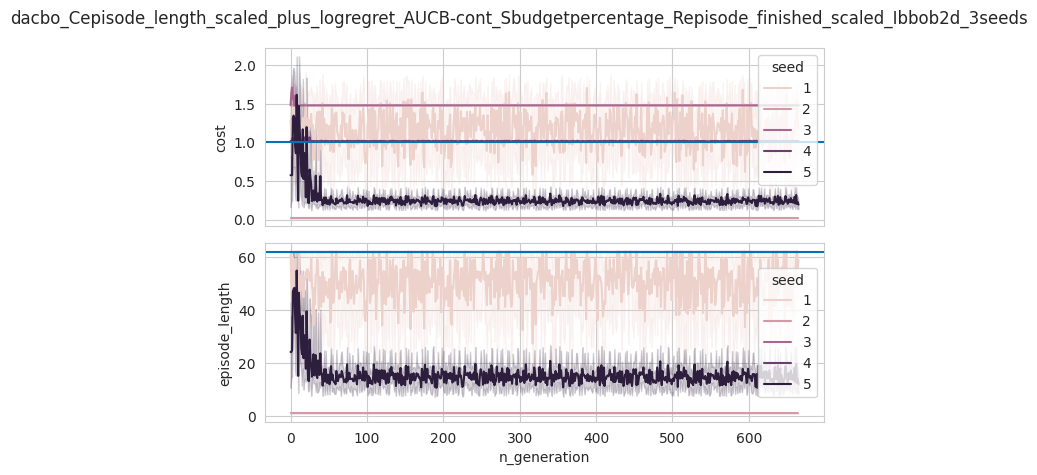

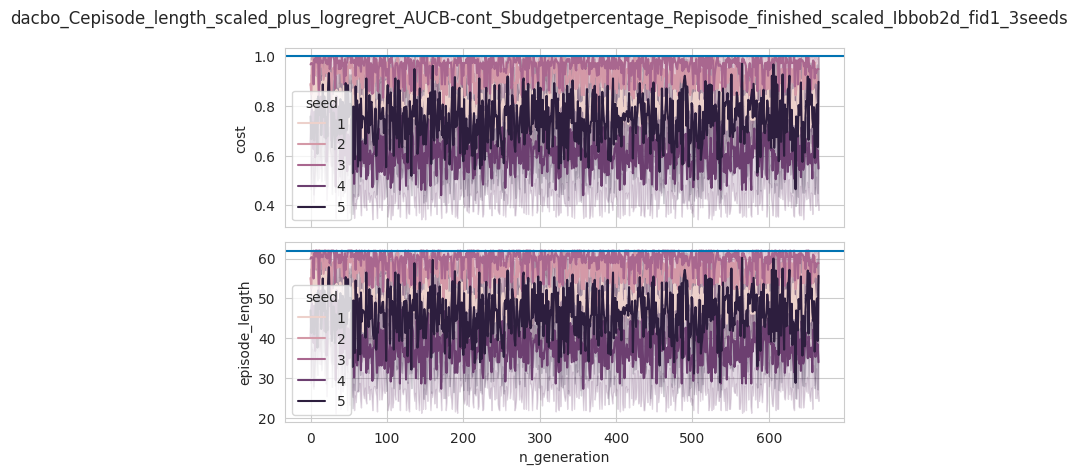

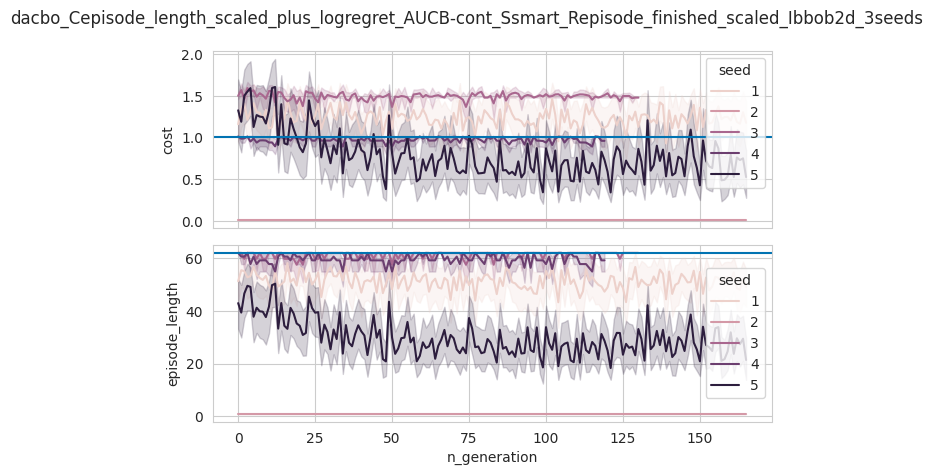

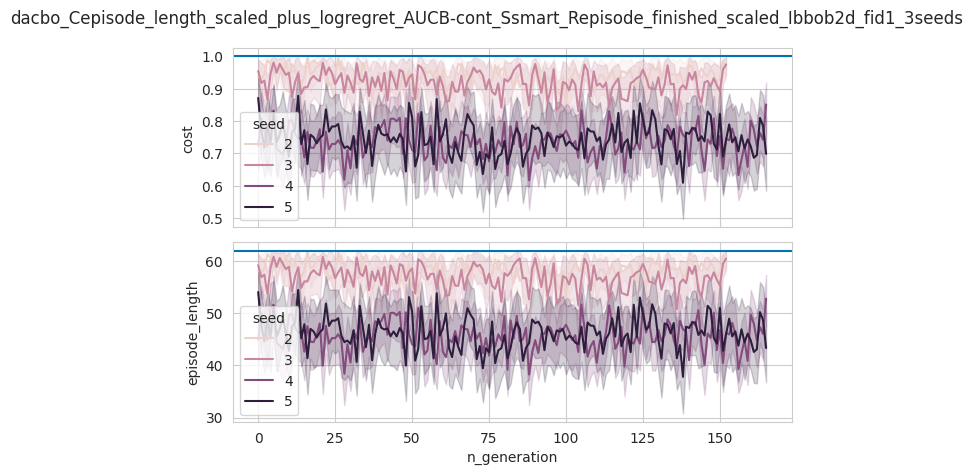

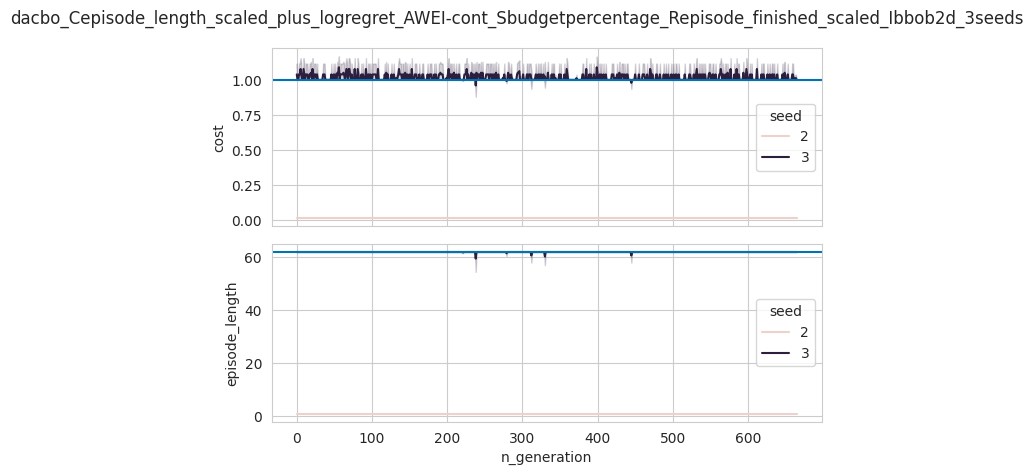

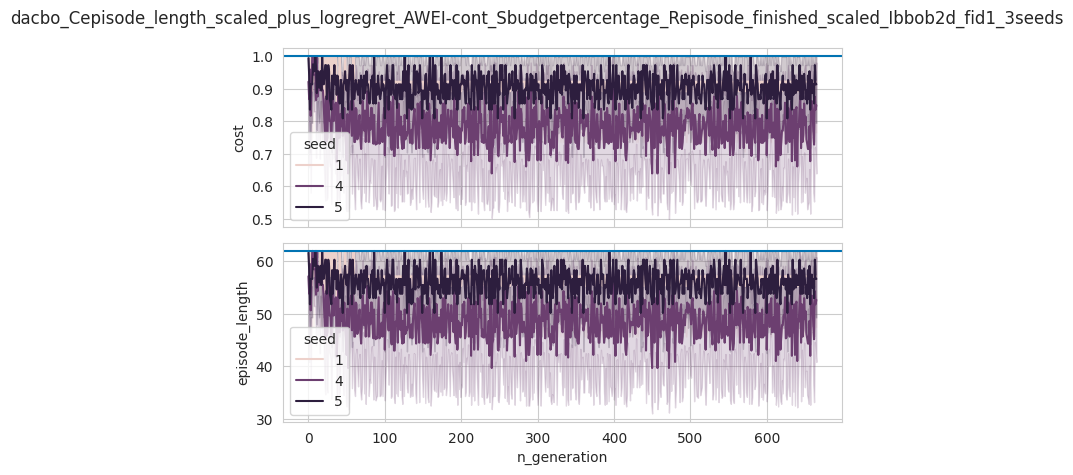

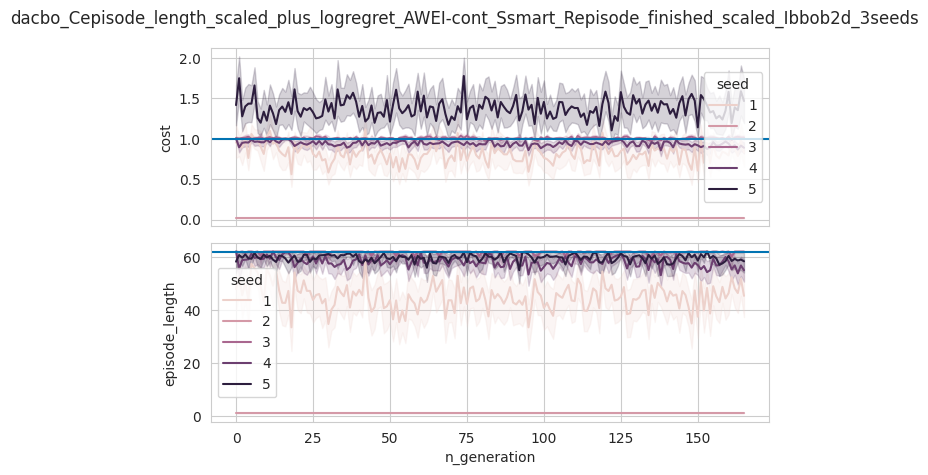

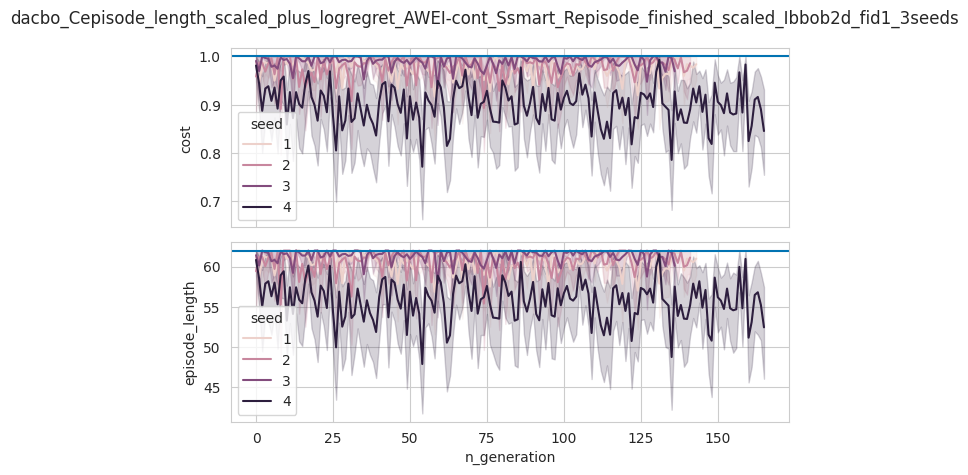

In [9]:
task_ep_length = 77 - 15

for task_id, group in logs.groupby("task_id"):
    fig = plt.figure()
    axes = fig.subplots(nrows=2, ncols=1, sharex=True, sharey=False)
    sns.lineplot(data=group, x="n_generation", y="cost", ax=axes[0], hue="seed")
    sns.lineplot(data=group, x="n_generation", y="episode_length", ax=axes[1], hue="seed")
    axes[0].axhline(1)
    axes[1].axhline(task_ep_length)
    fig.suptitle(task_id)
    fig.tight_layout()
    plt.show()